# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.645309,False,-0.655669
1,-1.290024,False,0.897509
2,-0.516777,True,3.997399
3,-1.182173,False,1.066280
4,-0.110748,False,-0.296572
...,...,...,...
995,-0.984761,False,-2.126056
996,-2.216479,False,-1.178628
997,-0.157410,False,-0.535397
998,0.795193,True,5.496686


<AxesSubplot:xlabel='v0'>

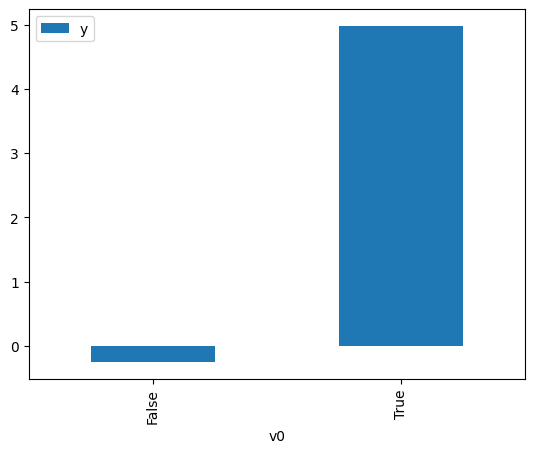

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

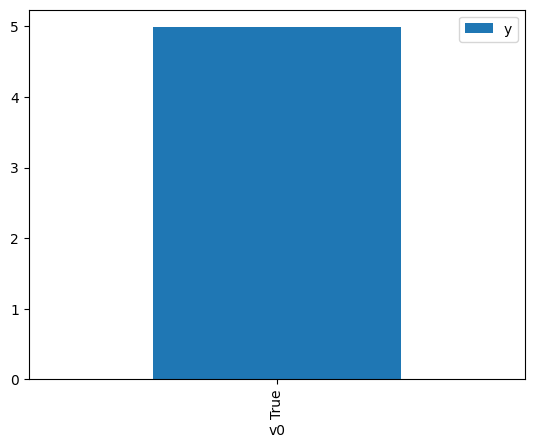

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.290722,False,-0.694540,0.990941,1.009142
1,-1.661686,False,-0.982968,0.967802,1.033269
2,-1.862345,False,-1.569662,0.978442,1.022033
3,-2.017421,False,-1.584337,0.984229,1.016024
4,-1.984946,False,0.120211,0.983159,1.017129
...,...,...,...,...,...
995,-0.166894,False,0.634041,0.582593,1.716465
996,-0.055916,False,-0.886246,0.526356,1.899856
997,-1.149622,False,-0.273393,0.913058,1.095221
998,-1.705399,False,-2.125338,0.970485,1.030413


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.418827,True,5.748499,0.051937,19.254172
1,0.164463,True,5.335115,0.585902,1.706771
2,-0.496322,True,5.600886,0.266992,3.745430
3,-0.769367,True,4.301246,0.172122,5.809838
4,-0.037251,True,5.158582,0.483209,2.069500
...,...,...,...,...,...
995,-0.604605,True,4.230409,0.225778,4.429134
996,-1.411608,True,5.585379,0.052672,18.985559
997,-0.105927,True,4.035850,0.448131,2.231489
998,0.047382,True,3.984477,0.526628,1.898875


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.888
Model:                            OLS   Adj. R-squared (uncentered):              0.887
Method:                 Least Squares   F-statistic:                              3938.
Date:                Fri, 02 Sep 2022   Prob (F-statistic):                        0.00
Time:                        00:36:36   Log-Likelihood:                         -1374.7
No. Observations:                1000   AIC:                                      2753.
Df Residuals:                     998   BIC:                                      2763.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.3600      0.023     15.346      0.000       0.314       0.406
x2             4.9378      0.057     86.037      0.000       4.825       5.050
==============================================================================
Omnibus:                        1.367   Durbin-Watson:                   1.924
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                1.387
Skew:                          -0.042   Prob(JB):                        0.500
Kurtosis:                       2.838   Cond. No.                         2.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""